In [4]:
from gekko import GEKKO

In [5]:
m = GEKKO(remote=False)

In [10]:
N = m.SV(name='nutrient')

In [11]:
a.name

'a'

In [6]:
np.arange(0,365*5,10)

array([   0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
        110,  120,  130,  140,  150,  160,  170,  180,  190,  200,  210,
        220,  230,  240,  250,  260,  270,  280,  290,  300,  310,  320,
        330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
        440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
        550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
        660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
        770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
        880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
        990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090,
       1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200,
       1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310,
       1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420,
       1430, 1440, 1450, 1460, 1470, 1480, 1490, 15

In [5]:

# to measure process time
import time as tm

In [6]:
import xsimlab as xs

Model was solved in 0.92 seconds


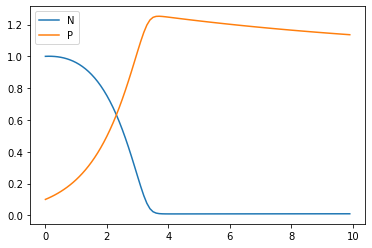

In [7]:
import numpy as np
from gekko import GEKKO
from scipy.integrate import odeint
import matplotlib.pyplot as plt

m = GEKKO(remote=False)    # create GEKKO model

halfsat_const = m.Param(0.1)
N0 = m.Param(1.)
inflow_rate = m.Param(0.1)
mortality_rate = m.Param(0.1)

N = m.SV(1, lb=0)
P = m.SV(0.1, lb=0)

t = np.arange(0,10,.1)
m.time = t

# Growth under nutrient limitation is described via Monod / Michaelis-Menten kinetics
nutlim = m.Intermediate(N/(N+halfsat_const)*P)
N_influx = m.Intermediate(N0 * inflow_rate)
mortality = m.Intermediate(P * mortality_rate)

m.Equation(N.dt()==N_influx - nutlim)
m.Equation(P.dt()==nutlim - mortality)

m.options.NODES = 3
m.options.IMODE = 7


solve_start = tm.time()
m.solve(disp=False)
solve_end = tm.time()

m.cleanup()
print(f"Model was solved in {round(solve_end - solve_start, 2)} seconds")
    
plt.plot(m.time, N, label='N')
plt.plot(m.time, P, label='P')
plt.legend()

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import xsimlab as xs

In [13]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [14]:
from phydra.utility.xsimlabwrappers import phydra_setup

In [15]:
from phydra.processes.main import GekkoCore, GekkoContext, GekkoSequentialSolve, Time

from phydra.processes.statevars import StateVariable, FunctionalGroup

from phydra.processes.fluxes import (InFlux, LinearExchangeFlux,LinearLossFlux, MonodUptake, Growth_MultiLim, 
                                    GML_MonodUptake, GML_EppleyTempLim, GML_SteeleLightLim,
                                    GrazingFlux, GrazingFlux_MultiRessource,
                                    QuadraticLossFlux, QuadraticExchangeFlux, Mixing, Upwelling)

from phydra.processes.forcings import ConstantForcing, SinusoidalForcing, GlobalSlabClimatologyForcing

from phydra.processes.paramsetup import GrowthParameterSetup

In [16]:
MODEL = xs.Model({
                # CORE
                'core':GekkoCore, 
                'solver':GekkoSequentialSolve, 

                'time':Time, 
                
                # STATE VARIABLES
                'N':StateVariable, 
                'P':StateVariable,
                
                # FLUXES
                
                #'monod':MonodUptake,
                'growth':Growth_MultiLim.setup('_P'),
                'monod':GML_MonodUptake.setup('_P'),
                
                'eppley':GML_EppleyTempLim.setup('_P'),
                'steele':GML_SteeleLightLim.setup('_P'),
                
                'P_mortality':LinearLossFlux,
    
                'N_upwelling': Upwelling,
                
                'Mixing':Mixing,
    
                # FORCING
                'N0':ConstantForcing,
                'Temp':ConstantForcing,
                'I0':ConstantForcing,
                'MLD':GlobalSlabClimatologyForcing,
                })

MODEL

<xsimlab.Model (16 processes, 33 inputs)>
core
solver
time
    days             [in] ('time',) time in days
N
    initVal          [in] initial value of component
P
    initVal          [in] initial value of component
Temp
    initVal          [in]
monod
    halfsat          [in] half saturation constant for Monod growth
eppley
    exponent         [in] exponent for Eppley Temperature dependenc...
    FX_label         [in]
steele
    FX_label_I0      [in] light forcing label
    IOpt             [in] optimal integrated irradiance
    kw               [in] light attenuation coefficient of sea water
    FX_label_MLD     [in] MLD forcing label
    kc               [in] light attenuation coefficient of componen...
MLD
    k                [in] The degree of the spline fit
    lon              [in]
    lat              [in]
    show_plot        [in] show plot of interpolated data and interp...
    rbb              [in]
    smooth           [in] smoothing conditions, larger values = str...
 

In [49]:
TIME = np.arange(0,365*5,.5)

in_ds = phydra_setup(model=MODEL,
                        input_vars={
                            'time__days': ('time', TIME),
                            
                            'N':{'initVal':1.},
                            'P':{'initVal':.1},
                            
                            'growth':{'source_label':'N',
                                    'sink_label':'P',
                                    'mumax':1.},
                            'eppley':{'FX_label':'Temp',
                                      'exponent':0.063},
                            'monod':{'halfsat':0.1},                            
                            'steele':{'FX_label_I0':'I0',
                                      'FX_label_MLD':'MLD',
                                      'IOpt':30.,
                                      'kw':0.04,
                                      'kc':0.03},
                            
                            
                            'P_mortality':{'SV_label':'P',
                                           'rate':0.13},
                            
                            'N_upwelling':{'SV_label':'N', #,'Z','D'],
                                      'FX_label_MLD':'MLD',
                                      'FX_label_N0':'N0',
                                      'kappa':0.13},
                            
                            'Mixing':{'SV_labels':['P'], #,'Z','D'],
                                      'FX_label_MLD':'MLD',
                                      'kappa':0.13},
                            
                            'N0':{'initVal':2}, #{'lat':47,'lon':-20,'rbb':2,'smooth':5, 'k':2,
                                 #  'dataset':'n0x'},#, 'show_plot':True},
                            'I0':{'initVal':20}, #{'lat':47,'lon':-20,'rbb':2,'smooth':10, 'k':2,
                                 #  'dataset':'par'},#, 'show_plot':True},
                            'MLD':{'lat':47,'lon':-20,'rbb':2,'smooth':40, 'k':2,
                                   'dataset':'mld'},#, 'show_plot':True},
                            'Temp':{'initVal':20}, #{'lat':47,'lon':-20,'rbb':2,'smooth':5, 'k':2,
                                  # 'dataset':'tmld'},#, 'show_plot':True},

                        },
                        output_vars={
                            # State Variables
                            'N__value':None,
                            'P__value':None,
                            
                            # Fluxes
                            'growth__value':None,
                            'P_mortality__value':None,
                            
                            # Forcing
                            'N0__value':None,
                            'MLD__value':None,
                            'MLD__deriv':None,
                            
                            # Forcing Fluxes
                            'N_upwelling__value':None,
                            'Mixing__values':None
                        })

In [50]:
with MODEL:
    out_ds = in_ds.xsimlab.run()

initializing model core
Initializing Model Time
state variable N is initialized
state variable P is initialized
forcing Temp is initialized
forcing MLD is initialized
[161.35449219 185.17585754 201.55308533 180.43736267  82.22182465
  35.41545486  23.00223732  19.88839531  21.0316143   34.70539093
  49.20352173  78.45903778 137.53314209 161.35449219] [  0.   15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.
 349.5 365. ]
[161.35449219 185.17585754 201.55308533 180.43736267  82.22182465
  35.41545486  23.00223732  19.88839531  21.0316143   34.70539093
  49.20352173  78.45903778 137.53314209 161.35449219] [  0.   15.5  45.   74.5 105.  135.5 166.  196.5 227.5 258.  288.5 319.
 349.5 365. ]
forcing I0 is initialized
forcing N0 is initialized
flux growth of P consuming N is initialized
flux P_mortality acting on P is initialized
flux N_upwelling acting on N is initialized
flux Mixing acting on ['P'] is initialized
['P']
[((p)*((((hpos+0.13))/(mld))))]
assembling equations for

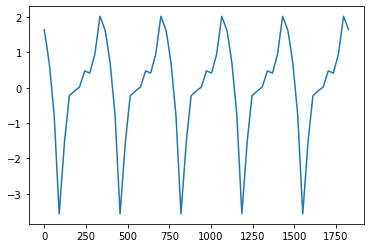

In [51]:
plt.plot(TIME, out_ds.MLD__deriv.values, label='P')

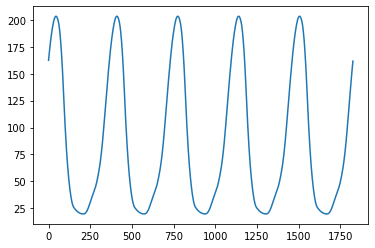

In [52]:
plt.plot(TIME, out_ds.MLD__value.values, label='P')

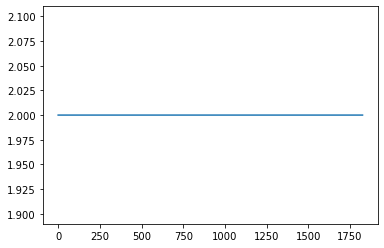

In [53]:
plt.plot(TIME, out_ds.N0__value.values, label='P')

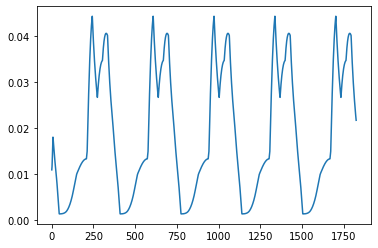

In [54]:
plt.plot(TIME, out_ds.N_upwelling__value.values, label='Mixing')

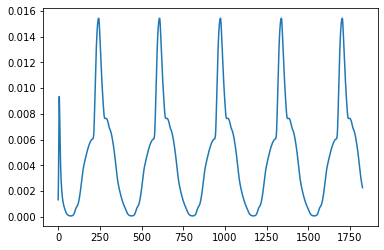

In [55]:
plt.plot(TIME, out_ds.Mixing__values.values[0], label='Mixing')

#plt.plot(TIME, out_ds.P__value.values, label='P')

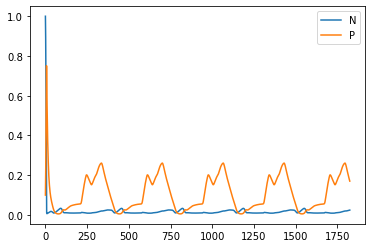

In [56]:
plt.plot(TIME, out_ds.N__value.values, label='N')
plt.plot(TIME, out_ds.P__value.values, label='P')
#plt.xlim((365*4,365*5))
plt.legend()

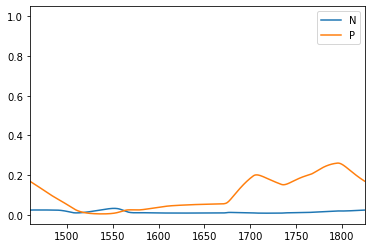

In [57]:
plt.plot(TIME, out_ds.N__value.values, label='N')
plt.plot(TIME, out_ds.P__value.values, label='P')
plt.xlim((365*4,365*5))
plt.legend()

# NEW TESTING GROUNDS

# return to basic simple model and check all processes, 

mixing is too complex to judge and debug

In [112]:
import xsimlab as xs
import numpy as np

In [113]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [13]:
from phydra.utility.xsimlabwrappers import phydra_setup

In [115]:
from phydra.processes.main import GekkoCore, GekkoContext, GekkoSequentialSolve, Time

from phydra.processes.statevars import StateVariable, FunctionalGroup

from phydra.processes.fluxes import (InFlux, LinearExchangeFlux,LinearLossFlux, MonodUptake, Growth_MultiLim, 
                                    GML_MonodUptake, GML_EppleyTempLim, GML_SteeleLightLim,
                                    GrazingFlux, GrazingFlux_MultiRessource,
                                    QuadraticLossFlux, QuadraticExchangeFlux, Mixing, Upwelling)

from phydra.processes.forcings import ConstantForcing, SinusoidalForcing, GlobalSlabClimatologyForcing

from phydra.processes.paramsetup import GrowthParameterSetup

In [116]:
from phydra.processes.forcings import Forcing

In [117]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.93.g5bac7e0.dirty


In [169]:
MODEL = xs.Model({
                # CORE
                'core':GekkoCore, 
                'solver':GekkoSequentialSolve, 

                'time':Time, 
                
                # STATE VARIABLES
                'N':StateVariable, 
                'P':StateVariable,
                'Z':StateVariable, 
                'D':StateVariable,
                
                # FLUXES
                # setup classmethod allows multiple instances of Growth_MultiLim process
                # and GML_... processes in same model
                  # Pro: flexible, Con: less understandable code
                
                #'monod':MonodUptake,
                'growth':Growth_MultiLim.setup('_P'),
                'monod':GML_MonodUptake.setup('_P'),
                
                'eppley':GML_EppleyTempLim.setup('_P'),
                'steele':GML_SteeleLightLim.setup('_P'),

                # note, grazing does not include setup class method (only 1 instance possible)
                  # (design choice not yet settled)
                'grazing':GrazingFlux_MultiRessource,
                
                'P_mortality':LinearExchangeFlux,
                'P_quadmortality':QuadraticExchangeFlux,
                'Z_mortality':LinearExchangeFlux,
                'Z_quadmortality':QuadraticLossFlux,
    
                'D_remin':LinearExchangeFlux,
    
                'N_input': InFlux,
    
                'Mixing':Mixing,
    
                'N_upwelling':Upwelling,
                
                # FORCING
                'N0':ConstantForcing,
                'Temp':GlobalSlabClimatologyForcing,
                'I0':GlobalSlabClimatologyForcing,
                'MLD':GlobalSlabClimatologyForcing,
                })

MODEL

<xsimlab.Model (24 processes, 71 inputs)>
core
solver
time
    days                [in] ('time',) time in days
N
    initVal             [in] initial value of component
P
    initVal             [in] initial value of component
Z
    initVal             [in] initial value of component
D
    initVal             [in] initial value of component
monod
    halfsat             [in] half saturation constant for Monod growth
MLD
    k                   [in] The degree of the spline fit
    dataset             [in] Options: 'n0x', 'mld', 'tmld', 'par'
    rbb                 [in]
    show_plot           [in] show plot of interpolated data and int...
    lon                 [in]
    lat                 [in]
    smooth              [in] smoothing conditions, larger values = ...
eppley
    FX_label            [in]
    exponent            [in] exponent for Eppley Temperature depend...
I0
    dataset             [in] Options: 'n0x', 'mld', 'tmld', 'par'
    show_plot           [in] show plot of inter

In [170]:
in_ds = phydra_setup(model=MODEL,
                        input_vars={
                            'time__days': ('time', np.arange(0, 365*3)),
                            
                            'N':{'initVal':0.1},
                            'P':{'initVal':.01},
                            'Z':{'initVal':.01},
                            'D':{'initVal':.01},
                            
                            'growth':{'source_label':'N',
                                    'sink_label':'P',
                                    'mumax':1.},
                            'monod':{'halfsat':0.5},
                            'eppley':{'FX_label':'Temp',
                                      'exponent':0.063},
                            'steele':{'FX_label_I0':'I0',
                                      'FX_label_MLD':'MLD',
                                      'IOpt':20.,
                                      'kw':0.04,
                                      'kc':0.03},
                            
                            'grazing':{'source_labels':['P','D'],
                                       'sink_label':'Z',
                                       'egested2_label':'D',
                                       'excreted2_label':'N',
                                       
                                       'Imax':1.,
                                       'kZ':0.6,
                                       'epsilon':0.75,
                                       'beta':0.69,
                                      
                                       'feed_prefs':[0.67, 0.33]},
                            
                            'P_mortality':{'source_label':'P',
                                           'sink_label':'D',
                                           'rate':0.015},
                            
                            'P_quadmortality':{'source_label':'P',
                                           'sink_label':'D',
                                           'rate':0.025},
                            
                            'Z_mortality':{'source_label':'Z',
                                           'sink_label':'D',
                                           'rate':0.02},
                            
                            'Z_quadmortality':{'SV_label':'Z',
                                           'rate':0.34},
                            
                            'D_remin':{'sink_label':'N',
                                       'source_label':'D',
                                       'rate':0.1
                                      },
                            
                            'N_input':{'SV_label':'N', #,'Z','D'],
                                      'FX_label':'N0',
                                      'rate':0.},
                            
                            'Mixing':{'SV_labels':['P', 'D'], #,'Z','D'],
                                      'FX_label_MLD':'MLD',
                                      'kappa':0.1},
                            
                            'N_upwelling':{'SV_label':'N',
                                      'FX_label_MLD':'MLD',
                                      'FX_label_N0':'N0',
                                      'kappa':0.1},
                            
                            'N0':{'initVal':1},#{'lat':40,'lon':20,'rbb':2,'smooth':1,
                                 #  'dataset':'n0x'},
                            'Temp':{'lat':40,'lon':20,'rbb':2,'smooth':100, 'k':2,
                                   'dataset':'tmld'}, #, 'show_plot':True},
                            'I0':{'lat':40,'lon':20,'rbb':2,'smooth':1000, 'k':2,
                                   'dataset':'par'},  #, 'show_plot':True},
                            'MLD':{'lat':40,'lon':20,'rbb':2,'smooth':400, 'k':2,
                                   'dataset':'mld'}#, 'show_plot':True}

                        },
                        output_vars={
                            # State Variables
                            'N__value':None,
                            'P__value':None,
                            'Z__value':None,
                            'D__value':None,
                            
                            # Fluxes
                            'growth__value':None,
                            'P_mortality__value':None,
                            'P_quadmortality__value':None,
                            'Z_mortality__value':None,
                            'Z_quadmortality__value':None,
                            'grazing__values':None,
                            
                            # Forcing
                            'N0__value':None,
                            'MLD__value':None,
                            'MLD__deriv':None,
                            'Temp__value':None,
                            'I0__value':None,
                            
                            # Forcing Fluxes
                            'N_upwelling__value':None,
                            'Mixing__values':None
                        })

In [171]:
with MODEL:
    out_ds = in_ds.xsimlab.run()

initializing model core
Initializing Model Time
state variable N is initialized
state variable P is initialized
state variable Z is initialized
state variable D is initialized
forcing MLD is initialized
forcing I0 is initialized
forcing N0 is initialized
forcing Temp is initialized
flux growth of P consuming N is initialized
flux grazing of Z consuming ['P' 'D'] is initialized 
 egesting to D and excreting to N
['P', 'D']
[((((((((1.0)*(((p)^(2)))))*(0.67)))/((0.36+((0+((((p)^(2)))*(0.67)))+((((d)^(2)))*(0.33)))))))*(z)), ((((((((1.0)*(((d)^(2)))))*(0.33)))/((0.36+((0+((((p)^(2)))*(0.67)))+((((d)^(2)))*(0.33)))))))*(z))]
flux P_mortality of D consuming P is initialized
flux P_quadmortality of D consuming P is initialized
flux Z_mortality of D consuming Z is initialized
flux Z_quadmortality acting on Z is initialized
flux D_remin of N consuming D is initialized
flux N_input of N0 flowing to N is initialized
flux Mixing acting on ['P' 'D'] is initialized
['P', 'D']
[((p)*((((hpos+0.1))/(

In [172]:
print(out_ds)

<xarray.Dataset>
Dimensions:                        (clock: 2, loss_index: 2, source_index: 2, time: 1095)
Coordinates:
  * clock                          (clock) int64 0 1
  * source_index                   (source_index) <U1 'P' 'D'
  * time                           (time) int64 0 1 2 3 ... 1091 1092 1093 1094
Dimensions without coordinates: loss_index
Data variables:
    D__initVal                     float64 0.01
    D__value                       (time) float64 0.01 0.009324 ... 0.09471
    D_remin__rate                  float64 0.1
    D_remin__sink_label            <U1 'N'
    D_remin__source_label          <U1 'D'
    I0__dataset                    <U3 'par'
    I0__k                          int64 2
    I0__lat                        int64 40
    I0__lon                        int64 20
    I0__rbb                        int64 2
    I0__show_plot                  bool False
    I0__smooth                     int64 1000
    I0__value                      (time) float64 23.58 23

In [173]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]

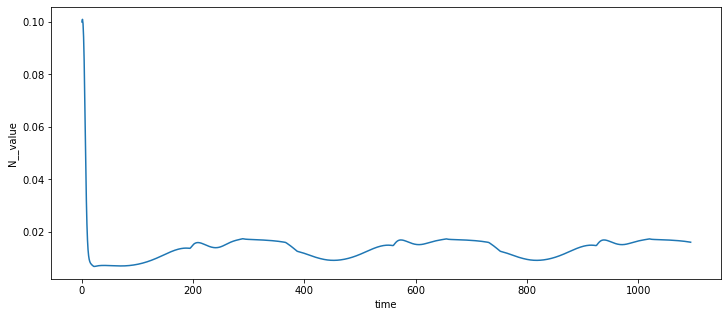

In [174]:
out_ds.N__value.plot.line(x='time')

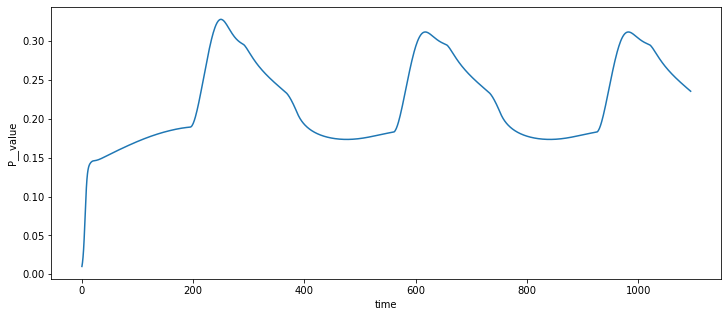

In [175]:
out_ds.P__value.plot.line(x='time')

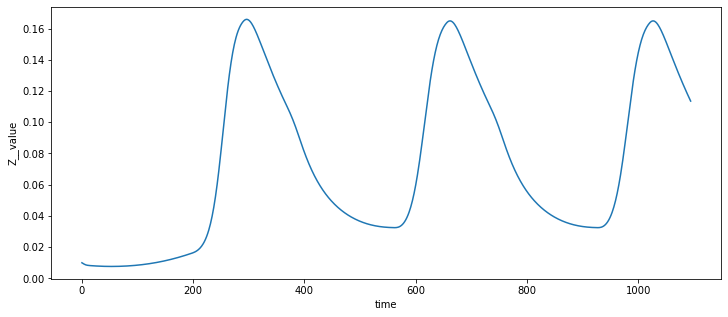

In [176]:
out_ds.Z__value.plot.line(x='time')

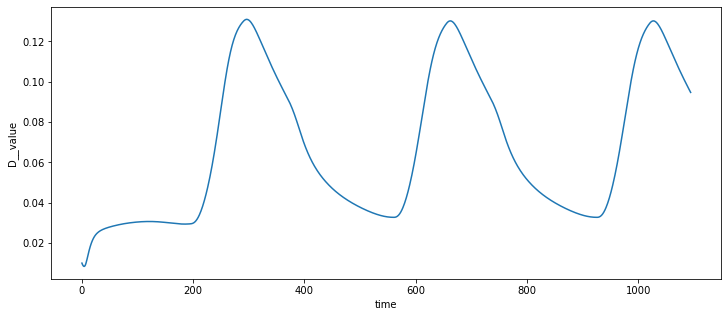

In [177]:
out_ds.D__value.plot.line(x='time')